# Summary of all the experiments done

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import os as os
from statsmodels.stats import multitest
from mpl_toolkits.mplot3d import axes3d  

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)

## I. Implementation of the pairwise competition - comparison with other models

### I.1 Idea
First assessment upon discovering the MESS model : the competition implemented compares the trait of each individual to the mean trait value for the community, which does not seem biologically very realistic to me. For example the that case, the blue individual would be favored above the green; which seems contrary to the niche theory which is being assumed when speaking about competition for ressource access.


<img src="./data_pics/trait_arrow.png" width="400">

Therefore, I implemented a model for pairwise competition : the distance to each other individual is computed pairwise !

In [4]:
#Neutral VS Pairwise VS mean 20 gen
cmp_pw = pd.read_csv("20gen_test_pw_vs_mean/pairwise_20gen/SIMOUT.txt", sep="\t", header=0)
cmp_neutral = pd.read_csv("20gen_test_pw_vs_mean/neutral_20gen/SIMOUT.txt", sep="\t", header=0)
cmp_mean = pd.read_csv("20gen_test_pw_vs_mean/mean_20gen/SIMOUT.txt", sep="\t", header=0)
# Sumstats start at "S" which is index 21, e.g. cmp_mean_res.iloc[:, 21:]
ss_start_idx = list(cmp_mean.columns).index("S")
ss_columns = cmp_mean.columns[21:]
# Param files used for the simulations are in the 20gen_test_pw_vs_mean/ directory

<IPython.core.display.Javascript object>


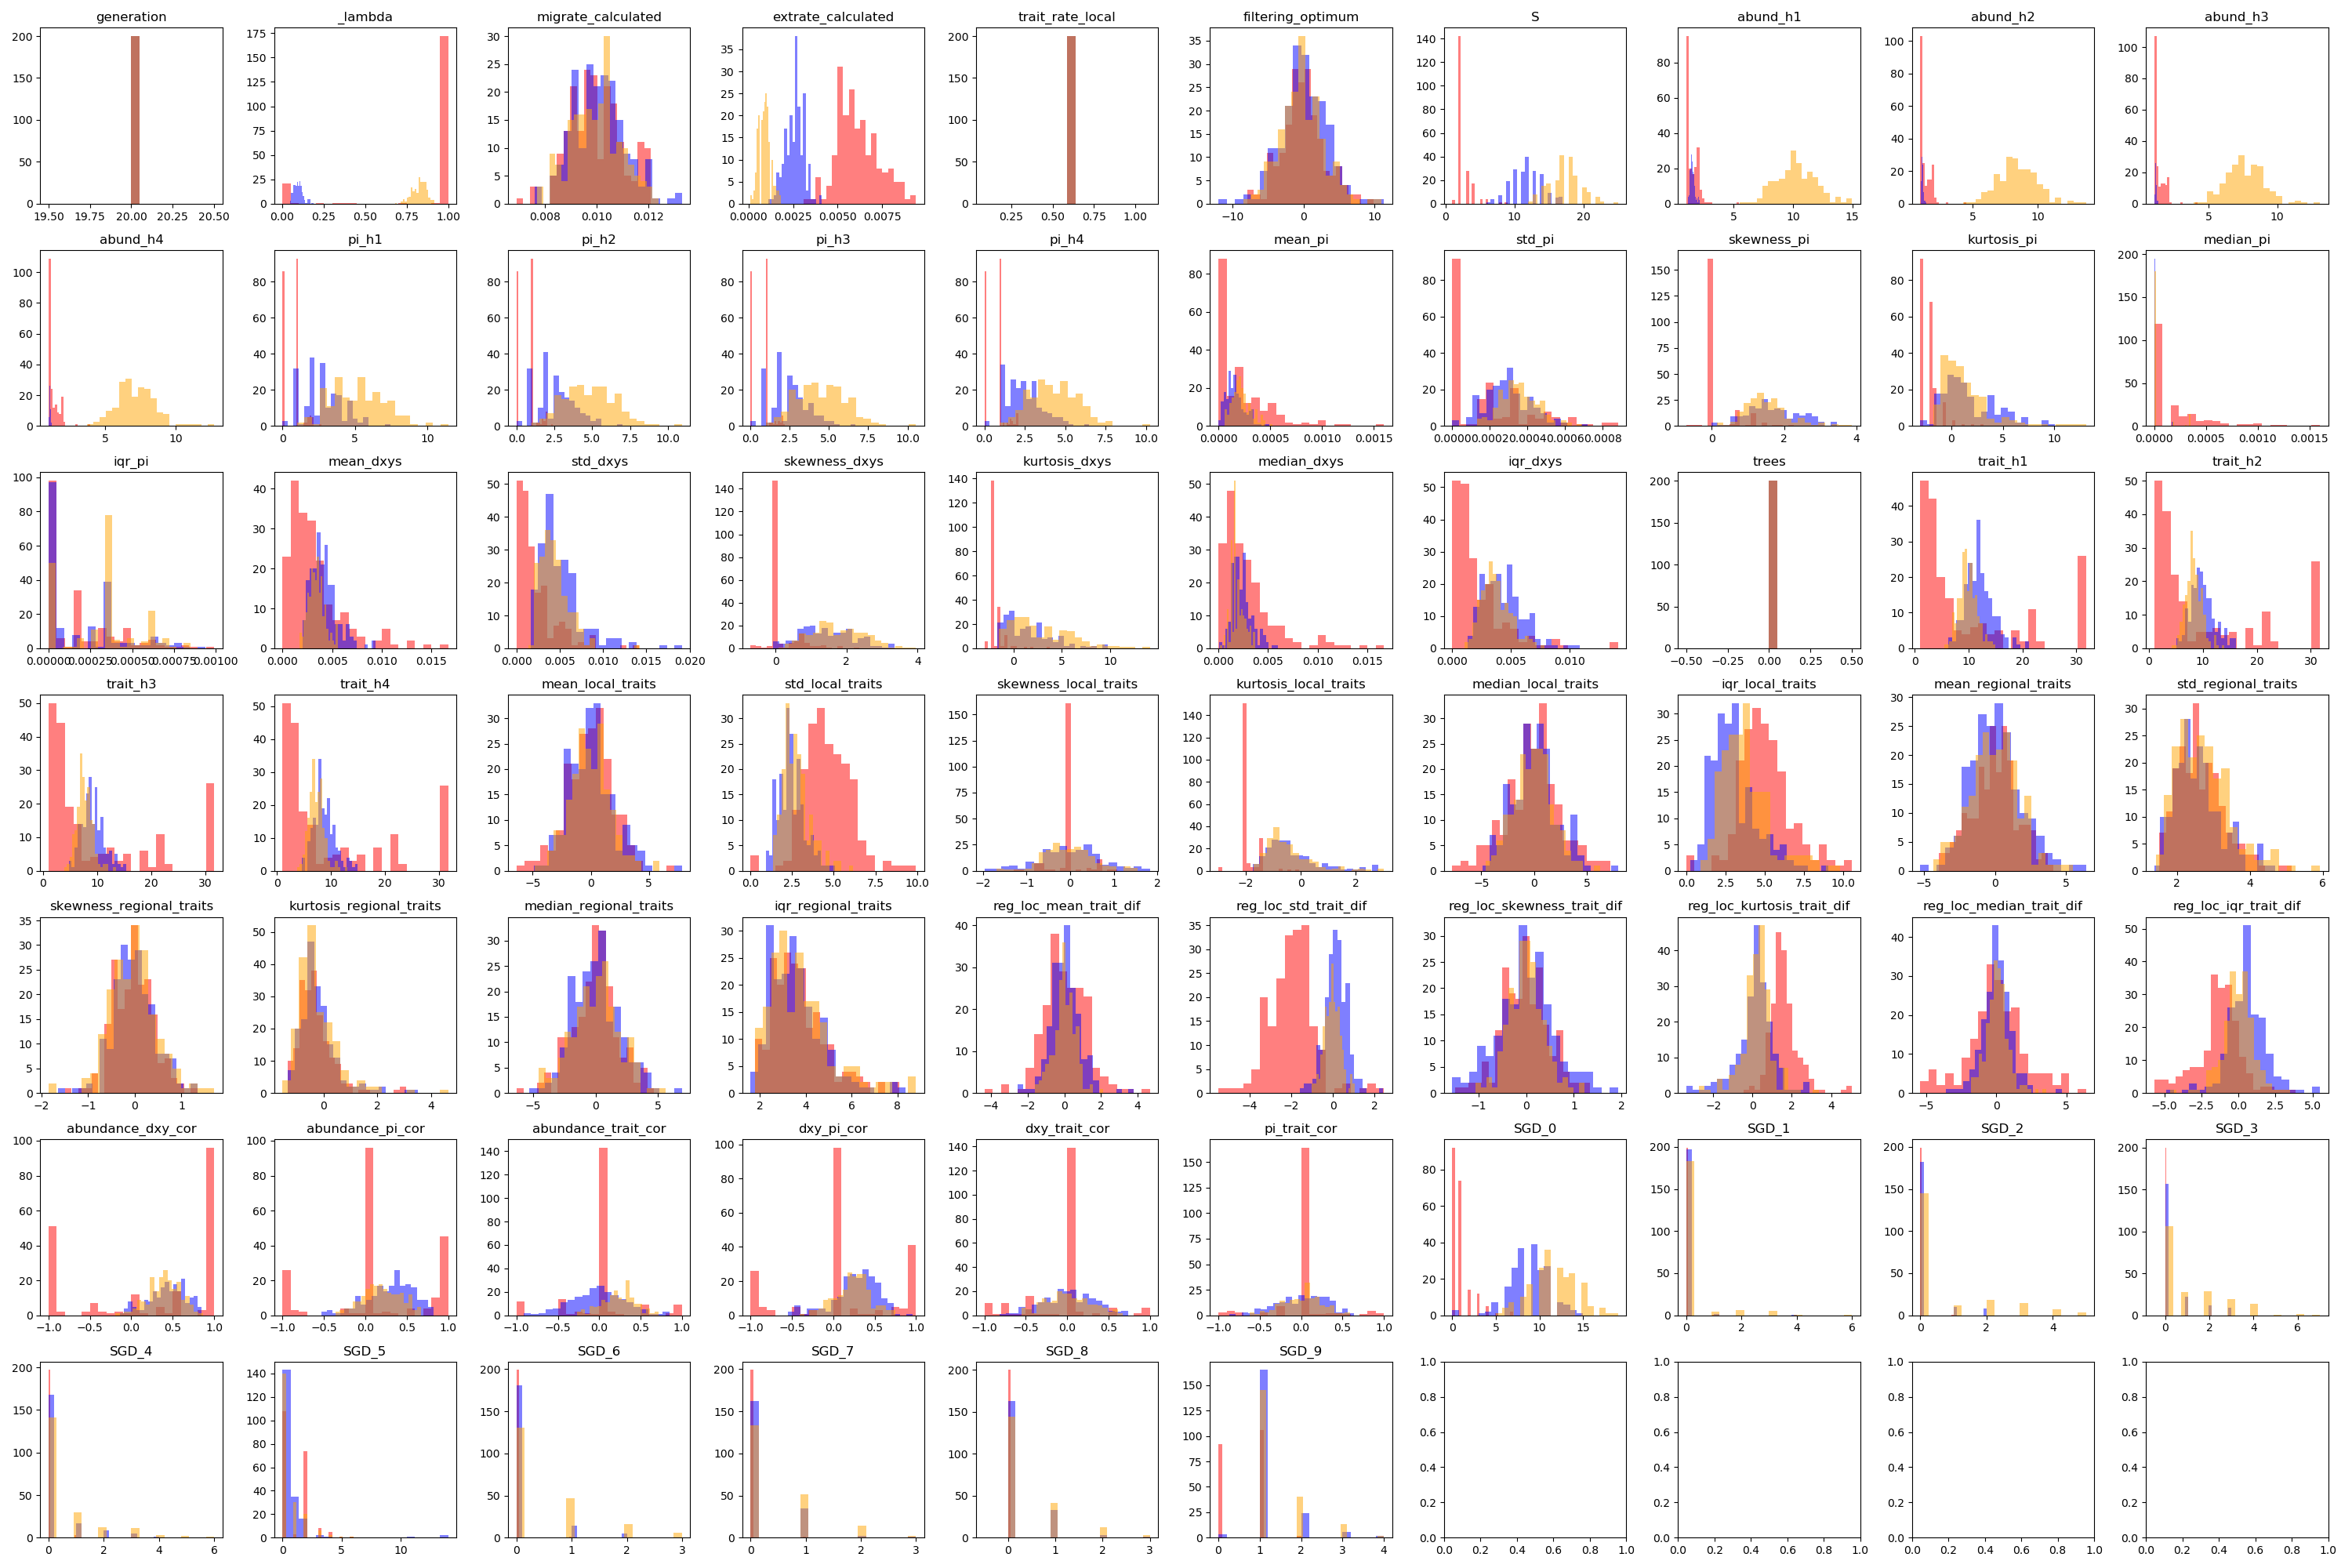

In [3]:
# neutral is blue
# pairwise is orange
# mean is red
fig, ax = plt.subplots(7, 10, figsize=(30, 20))
axs = fig.axes
for p, ax in zip(list(cmp_mean.columns)[15:], axs):
    ax.hist(cmp_mean[p], color='red',bins=20,alpha=0.5)
    ax.hist(cmp_neutral[p], color='blue', bins=20, alpha=0.5)
    ax.hist(cmp_pw[p], color='orange', bins=20, alpha=0.5)
    ax.set_title(p)
fig.tight_layout()

### I.2 What the hell is that graph ? Summary statistics short explanation
In this graph we can see the numerous summary statistics used to describe the results of the simulations. They essentially measure the biodiversity along three axis : i) species richness and abundance; ii) population genetic diversity; and iii) trait variation in a phylogenetic context.

More precisely, those axis are described through the Hill numbers (measure the evenness of distribution), and some more classical measures (mean, std, median, skewness, etc.)

Our assumption is that these summary statistics can allow us to descrimate among the different communiy assembly models, and then be used to predict the other parameters thanks to machine learning.

### I.3 Conclusion :
Pairwise competition clearly behaves differently from the mean competition, which proves that the mean formula is different (no convergence).

Regarding these differences, it might be worth to re-try the inference made for the MESS paper (mostly pointing toward neutral model being dominant) to check whether this new kind of competition could be what is actually happening.

However, the simulations are very slow right now, so it is necessary to do some code optimisation. It shall not be forgotten the the graphes above are what happen for just 20 generations, which is very short.

## II. Speed comparison with and without array

To compare all the models, 50 simulations were run for 200 generations for each model with all parameters being otherwise equal and chosen to be closed to the values inferred from empirical data by the MESS model. To increase the speedof the simulations, I changed the way the Local Community was managed (from lists to arrays), obtaining the following results : (values are the mean of 50 simulations, +/- standard deviation, in seconds)

<div id="speed">

| **Model**                   | **Without arrays** | **With arrays** | **Ratio noarray/array** |
| :-------------------------- | :----------------- | :-------------- | :---------------------- |
| **Neutral**                 | \(9 +/- 2\)        | \(24 +/- 3\)    | 0.375                   |
| **Mean competition**        | \(456 +/- 114\)    | \(89 +/- 11\)   | 5.14                    |
| **Pairwise competition**    | \(1944 +/- 258\)   | \(323 +/- 40\)  | 6.02                    |
| **Environmental filtering** | \(80 +/- 18\)      | \(70 +/- 10\)   | 1.14                    |
| **Interaction matrix**      | *no runs*          | \(419 +/- 54\)  | *no runs*               |

</div>

Noticeably, this greatly increased the speed of both competition model
thus making further modelling and testing of MESS possible, even if the
speed of the neutral mode was on contrary increased (due to the
management of arrays not useful in this case). The value for the
interaction matrix is here to give a point of comparison.

*Remark: param files used for the simulations were generated by the speedtest.sh (see speed/ directectory)*

## III. Reliability of the array and interaction matrix implementations

Having faster simulations is good, having been able to prove that they work in the same way as previously is better.

In [3]:
#200 generations ; 4 models ; alpha 2000 ro 7000 ; m 0.001 or 0.01 ; s 0.001 or 0.01
# J 1000; point_mutation; all defaults otherwise
# ecological strength 1 (contrary to speedtest : 0.3)
# Testing array VS non array
# ! Unequals number of simulations : 
#           ARRAYS      NOARRAYS
# mean      60          160
# filtering 210         210
# pairwise  160         225
# neutral   210         210
# (Because I had to relaunch some exp, and relaunched more than expected without noticing + it was painfull to 
# try to relaunch noarray exp cause I had deleted the code )
arr_mean = pd.read_csv("array_noarray/array_mean/SIMOUT.txt", sep="\t", header=0)
arr_pw = pd.read_csv("array_noarray/array_pw/SIMOUT.txt", sep="\t", header=0)
arr_neutral = pd.read_csv("array_noarray/array_neutral/SIMOUT.txt", sep="\t", header=0)
arr_filtering = pd.read_csv("array_noarray/array_filtering/SIMOUT.txt", sep="\t", header=0)
noarr_mean = pd.read_csv("array_noarray/noarray_mean/SIMOUT.txt", sep="\t", header=0)
noarr_pw = pd.read_csv("array_noarray/noarray_pw/SIMOUT.txt", sep="\t", header=0)
noarr_neutral = pd.read_csv("array_noarray/noarray_neutral/SIMOUT.txt", sep="\t", header=0)
noarr_filtering = pd.read_csv("array_noarray/noarray_filtering/SIMOUT.txt", sep="\t", header=0)
#All param files are in array_noarray folder

In [6]:
# Compute pvalues for differences in summary statistics
# With Bonferroni correction for multiple testing
ttvals_mean, ttres_mean = stats.ttest_ind(arr_mean.iloc[:, 21:], noarr_mean.iloc[:, 21:])
ttres_mean = multitest.multipletests(ttres_mean,method='bonferroni')

ttvals_pw, ttres_pw = stats.ttest_ind(arr_pw.iloc[:, 21:], noarr_pw.iloc[:, 21:])
ttres_pw = multitest.multipletests(ttres_pw,method='bonferroni')

ttvals_neutral, ttres_neutral = stats.ttest_ind(arr_neutral.iloc[:, 21:], noarr_neutral.iloc[:, 21:])
ttres_neutral = multitest.multipletests(ttres_neutral,method='bonferroni')

ttvals_filtering, ttres_filtering = stats.ttest_ind(arr_filtering.iloc[:, 21:], noarr_filtering.iloc[:, 21:])
ttres_filtering = multitest.multipletests(ttres_filtering,method='bonferroni')
# In fact : everything is 1. Idk why there's a nan
print(ttres_filtering[1])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


<IPython.core.display.Javascript object>


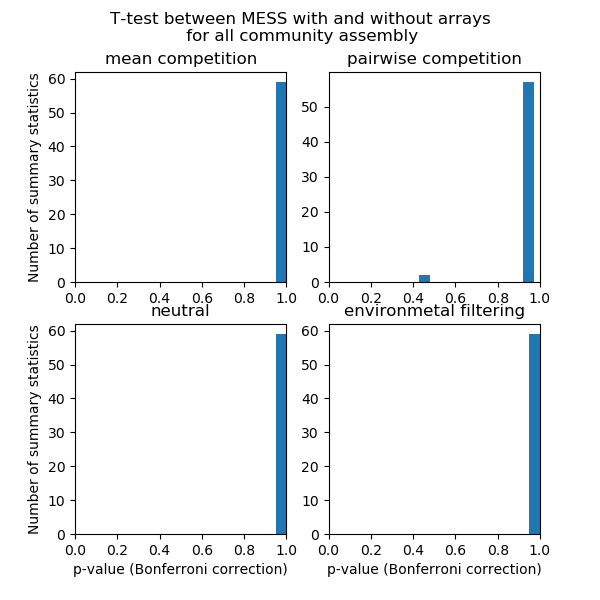

In [9]:
fig = plt.figure(figsize=(6,6))

#===============
#  First subplot
#===============
ax = fig.add_subplot(2, 2, 1)


ax.hist(ttres_mean[1],align='left')
ax.set_xlim(0,1)
ax.set_ylabel("Number of summary statistics")
ax.set_title("mean competition")

ax = fig.add_subplot(2, 2, 2)
ax.hist(ttres_pw[1], align='left')
ax.set_xlim(0,1)
ax.set_title("pairwise competition")

ax = fig.add_subplot(2, 2, 3)
ax.hist(ttres_neutral[1], align='left')
ax.set_xlabel("p-value (Bonferroni correction)")
ax.set_xlim(0,1)
ax.set_ylabel("Number of summary statistics")
ax.set_title("neutral")

ax = fig.add_subplot(2, 2, 4)
ax.hist(ttres_filtering[1], align='left')
ax.set_xlabel("p-value (Bonferroni correction)")
ax.set_xlim(0,1)
ax.set_title("environmetal filtering")

plt.suptitle("T-test between MESS with and without arrays\n for all community assembly")
plt.show()

### Conclusion : 
The new implementation, which changed the managing of the local community (and their traits) from lists to arrays does not seem to have distrubed the simulations : the obtained summary statistics are the same as before.

This increased speed allows us to have a global graph of the summarys statistics to show the different behaviour of the models:

<IPython.core.display.Javascript object>


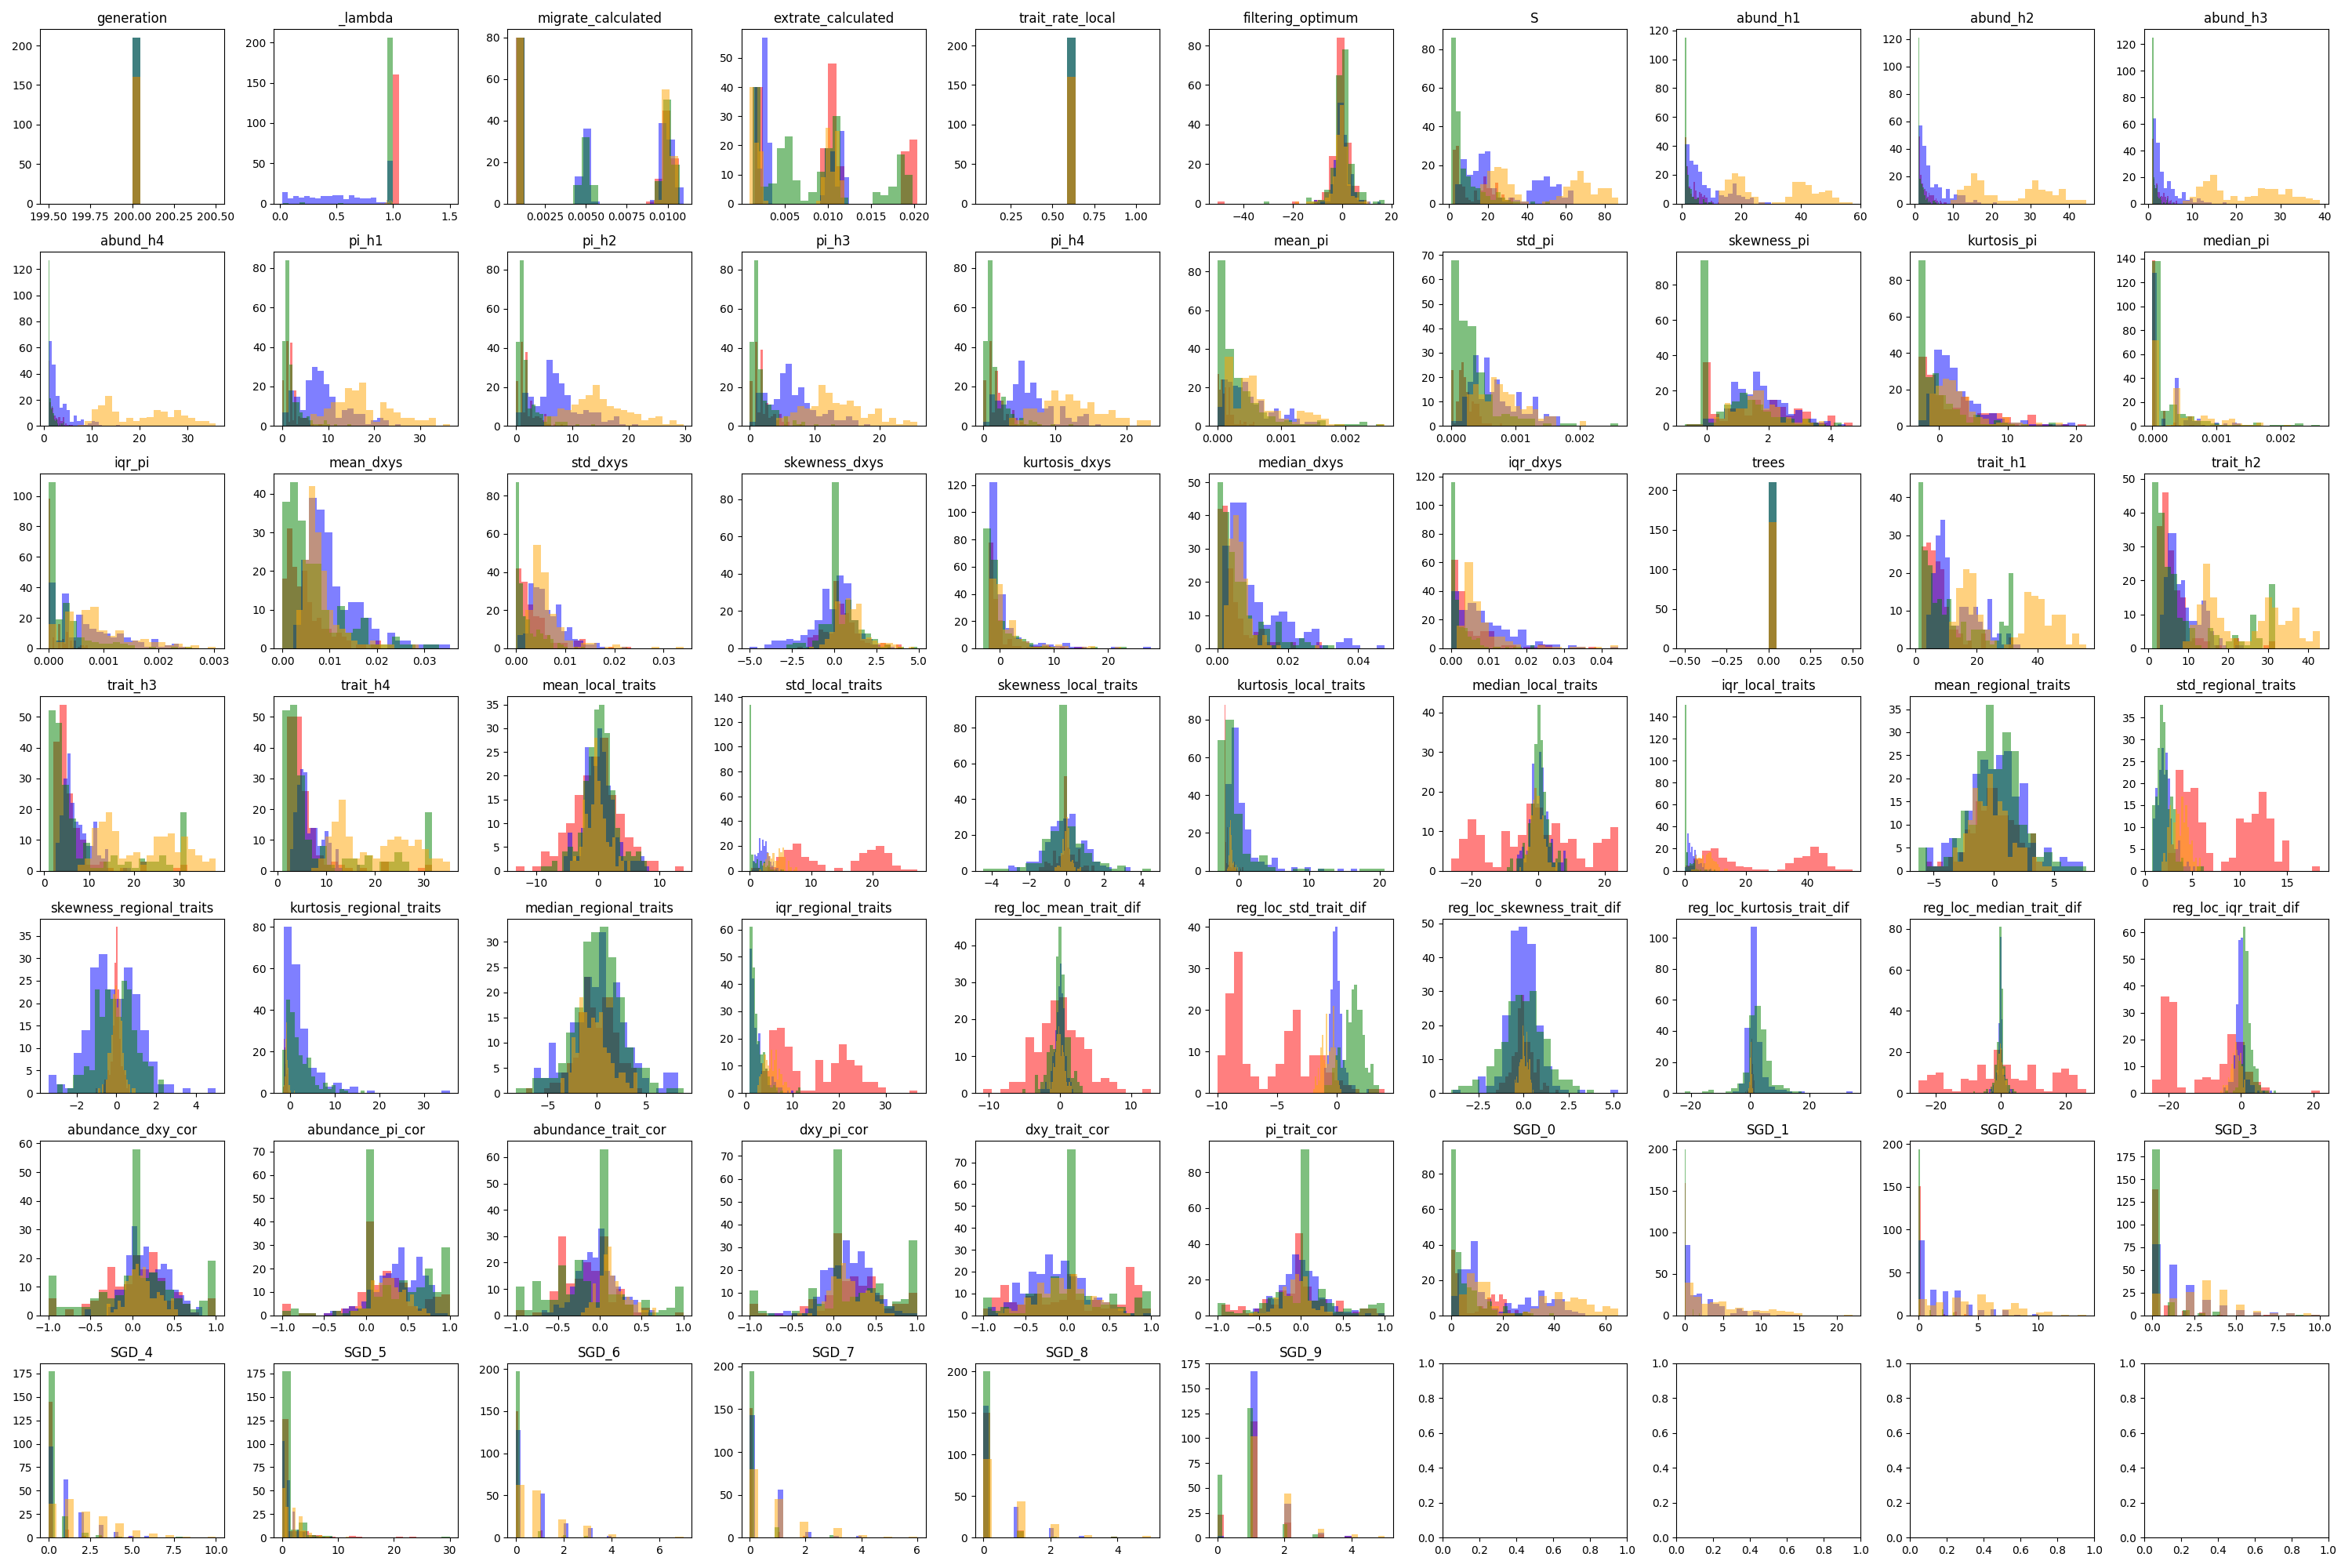

In [6]:
# ALL
#200 generations ; 4 models ; alpha 2000 or 7000 ; m 0.001 or 0.01 ; s 0.001 or 0.01
# J 1000; point_mutation; all defaults otherwise
# ecological strength 1
fig, ax = plt.subplots(7, 10, figsize=(30, 20))
axs = fig.axes
for p, ax in zip(list(arr_pw.columns)[15:], axs):
    ax.hist(arr_mean[p], color='red', bins=20, alpha=0.5)
    ax.hist(arr_neutral[p], color='blue', bins=20, alpha=0.5)
    ax.hist(arr_filtering[p], color='green', bins=20, alpha=0.5)
    ax.hist(arr_pw[p], color='orange', bins=20, alpha=0.5)
    ax.set_title(p)
fig.tight_layout()


Quite surprisingly, the pairwise competition gives results very similar to the neutral (ex: more to the right most hill numbers related to abundance. Since this measures the eveness of the distribution. This will be investigated in the next section.

Another remark is that in the current pairwise competition model, the intraspecific competition is the highest since all individual of a species have the same trait value. To be able to correct this, a model with an interaction matrix, regulating the interaction between each species (and enabling mutualism) has been proposed.



Supposedely, if the matrix is filled with 1 we should expect the results to be same as the pairwise competition witout matrix. Here, we assess for this:

## IV. Interaction matrix

Reminder : the 3 death probabilities formula : (they are always normalized so that the sum for the whole population is 1)
* Filtering :
$$
P(z_i) = \exp\left({-\frac{(z_i-z_E)^2}{t_z}}\right)
$$
* Mean competition :
$$
P(z_i) = 1 - \exp\left({-\frac{(z_i-\overline{z})^2}{t_z}}\right)
$$
* Pairwise competition :
$$
P(z_i) = 1 - \sum_{j\neq i} \exp\left({-\frac{(z_i-z_j)^2}{t_z}}\right)
$$


If you look more cloesly at the formula for pairwise competition, you can note that it compares each individual to all the others, including those of the same species, who have the exact same trait value. Thus, the highest competition with the current model is the intraspecific competition.

To loosen this restriction inherent to the model, and enable it to be more finely tuned, a new factor was introduced in the formula : 

$$
P(z_i) = 1 - \sum_{j\neq i} -\alpha_{ij} \exp\left({-\frac{(z_i-z_j)^2}{t_z}}\right)
$$

This implies that there is an interaction matrix specifying the strength and nature of the interaction between any two species. We can imagine having different coefficient for every species (random distribution), or just two values (intra- or interspecifid competition) : there is a whole new world to explore !

This was implemented (and verified) in the project :
(data in array_noarray/matrix_assessment/SIMOUT.txt)

<img src="./data_pics/ttest_noarray_pw_matrix.png" width="400">

## V. Emergeant neutrality

According to the theory of emergeant neutrality, apparently neutral patterns could emerge from complex ecological dynamics (among which there is compeition), making it hard to impossible for us to tell both paradigms apart.

In our experiments, it seems that simulations run with the pairwise competition community assembly model end up looking like the neutral simulation. To investigate at which level this convergence occurs (and whether there is a way to tell both models apart), I looked into the experiments more in details.

The difference between all community assembly models is at the death step : either the individual is chosen randomly or according to weighted probabilities. We will look at these probabilities to see if the convergence is at the deepest level (= all individual being in fact equally likely to die)

### V.1 First approach : looking at the deaths probabilities
All results are in the folder plots/deaths_probs_plots (not on git because it is too heavy). 
Params: 100 750000 2.0 0.7 2.0 0.3 200 0.0 7000 570 1000 0.005 0.001
(S_m J_m speciation_rate death-proportion trait_rate_meta ecological_strength generations  mutation_rate alpha sequence_length J m speciation_prob)

TO RELAUNCH (parameters are not the same for all simulations)

<div style="display: flex; justify-content: row;">
    Death probability per species for &nbsp;<b> pairwise competition</b>
    <img src="./data_pics/pairwise_competition_death_probabilities_persp.gif" width="500">
    </div>
<div style="display: flex; justify-content: row;">
    Death probability per individual for &nbsp;<b> pairwise competition</b>
    <img src="./data_pics/pairwise_competition_death_probabilities.gif" width="500">

</div>

<div style="display: flex; justify-content: row;">
    Death probability per species for &nbsp;<b> neutral</b>
    <img src="./data_pics/neutral_death_probabilities_persp.gif" width="500">
    </div>

<div style="display: flex; justify-content: row;">
    Death probability per individual for &nbsp;<b> neutral</b>
    <img src="./data_pics/neutral_death_probabilities.gif" width="500">

</div>

<div style="display: flex; justify-content: row;">
    Death probability per species for &nbsp;<b> filtering</b> (! not same time length)
    <img src="./data_pics/filtering_death_probabilities_persp.gif" width="500">
    </div>

<div style="display: flex; justify-content: row;">
    Death probability per individual for &nbsp;<b> filtering</b> (! not same time length)
    <img src="./data_pics/filtering_death_probabilities.gif" width="500">

</div>


<div style="display: flex; justify-content: row;">
    Death probability per species for &nbsp;<b> mean competition</b> (! not same time length)
    <img src="./data_pics/competition_death_probabilities_persp.gif" width="500">
    </div>

<div style="display: flex; justify-content: row;">
    Death probability per individual for &nbsp;<b> mean competition</b> (! not same time length)
    <img src="./data_pics/competition_death_probabilities.gif" width="500">

</div>






However, and even if it looks the death probabilities in the pairwise competition model tends to converge toward neutral probabilities, this only gives a very rough idea for a few simulations of what might be happening. Moreover, this seems to aslo happen for the other types of simulations : we need a more robust test to see whether there is a structural convergence toward neutrality.

This is why I coded a test recording each few generation whether the simulation is neutral or not (Pearson's chi-squared test - threshold 0.1). This was then studied for all 4 models, for a various range of parameters. See results below (V.3) (mean of neutrality status over the 25 last generations of 500-generations-long experiments)

### V.2 Trait value distribution

We can also look at the trait evolution through time, rather than directely at the death probabilities:

TO RELAUNCH (code unavailable now : transition to replicable experiences)

Traits values and death probabilities through time for &nbsp;<b> pairwise competition</b>
  <div style="display: flex; justify-content: row;">
    <img src="./data_pics/traits_pw.gif" width="500">
</div>

Traits values and death probabilities through time for &nbsp;<b> mean competition</b>
  <div style="display: flex; justify-content: row;">
    <img src="./data_pics/traits_mean.gif" width="500">
</div>

Traits values and death probabilities through time for &nbsp;<b> environmental filtering</b>
  <div style="display: flex; justify-content: row;">
    <img src="./data_pics/traits_filt.gif" width="500">
</div>
It looks like the trait values are extremely close to one another for the pairwise competition - contrary to what was expected: Bug in the code or real behaviour ?

Interesting fact : seems to have a relatively high diversity, that is afterward counter-selected : only the fittest survives. Thus, the pairxise competition could not explain long term biodiversity ?


### V.3 Impact of ecological strength on the convergence toward neutrality
#### V.3.1 Environmental fitlering

In [13]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)

header = ["timesteps","is_neutral", "g_through_time", "S_m", "J_m", "speciation_rate", "death_proportion", "trait_rate_meta",	"ecological_strength",
          "intrasp_competition", "intersp_competition", "mutualism_proportion",	"generations", "community_assembly_model", "speciation_model",
          "mutation_rate", "alpha", "sequence_length", "J", "m", "speciation_prob", "generation",  "_lambda", "migrate_calculated",
          "extrate_calculated", "trait_rate_local",	"filtering_optimum", "S", "abund_h1", "abund_h2", "abund_h3", "abund_h4", "pi_h1", "pi_h2",
          "pi_h3", "pi_h4", "mean_pi", "std_pi", "skewness_pi", "kurtosis_pi", "median_pi", "iqr_pi",  "mean_dxys", "std_dxys",
          "skewness_dxys", "kurtosis_dxys",	"median_dxys", "iqr_dxys",	"trees",	"trait_h1",	"trait_h2",	"trait_h3",	"trait_h4",	"mean_local_traits",
          "std_local_traits",	"skewness_local_traits",	"kurtosis_local_traits", "median_local_traits",	"iqr_local_traits",	"mean_regional_traits",
          "std_regional_traits",	"skewness_regional_traits",	"kurtosis_regional_traits",	"median_regional_traits",	"iqr_regional_traits",	"reg_loc_mean_trait_dif",
          "reg_loc_std_trait_dif",	"reg_loc_skewness_trait_dif",	"reg_loc_kurtosis_trait_dif",	"reg_loc_median_trait_dif",	"reg_loc_iqr_trait_dif",	
          "abundance_dxy_cor",	"abundance_pi_cor",	"abundance_trait_cor",	"dxy_pi_cor",	"dxy_trait_cor",	"pi_trait_cor",	"SGD_0",	"SGD_1",	"SGD_2",
          "SGD_3",	"SGD_4", "SGD_5", "SGD_6", "SGD_7", "SGD_8", "SGD_9"]


In [21]:
filt500 = pd.DataFrame(columns=header)
for folder in os.listdir('./filtering_es'):
    if os.path.isdir('./filtering_es/'+folder) and folder!=".ipynb_checkpoints":
        text_file = open('./filtering_es/'+folder+"/is_neutral.txt", "r")
        results = text_file.read().split('\n')
        typ = results[-1]
        typ = typ.split('\t')
        typint = []
        for i in range(len(typ)):
            try:
                typint += [float(typ[i])]
            except:
                typint += [typ[i]]
        results = results[:-2]
        results = np.array([[float(j) for j in i.split('\t')] for i in results]).T
        results = results.tolist()
        for i,t in enumerate(typint):
            results += [t]
        d = {header[i]:results[i] for i in range(len(header))}
        res = pd.Series(d, name=str(folder))
        if d["generation"]-500<1:
            filt500 = filt500.append(res)


<IPython.core.display.Javascript object>


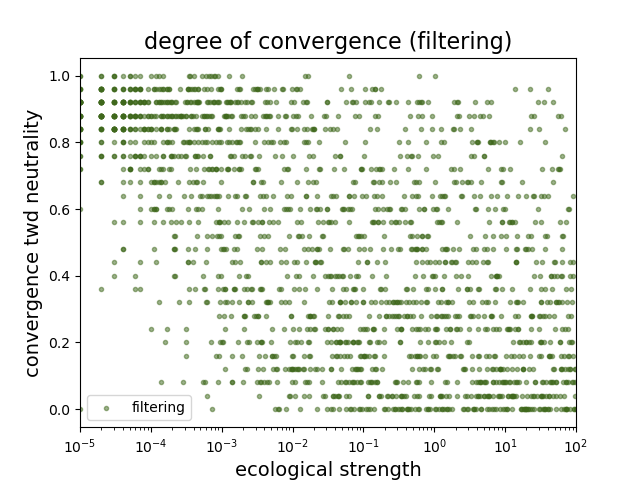

In [22]:
X = filt500["ecological_strength"]
Y = [np.mean(filt500["is_neutral"][i][-25:]) for i in range(len(filt500))]
plt.scatter(X,Y,color="#3F681C", label="filtering", alpha=0.5, marker='.')
plt.xscale('log')
plt.xlim(1e-5,100)
plt.ylabel('convergence twd neutrality',size=14)
plt.xlabel('ecological strength',size=14)
plt.title("degree of convergence (filtering)",size=16)
plt.legend()
plt.show()

This gives the impression that the degree of convergeance toward neutrality is really wide spread, and the the ecological strength has therefore little impact.

*Hypothesis:* The trait value converges quickly toward the optimum when es is high, and then all surviving species are more or less equivalent, so it becomes more "neutral" even for the highest values of ecologicial strength. For the lowest values, this convergence still occurs but takes more time; thus resulting in non-neutral simulations at some point (allows higher divergence in trait values for the surviving species ?

*Hypothesis testing:* Look at the convergence for different time step + Look at the trait value distribution as a function of the ecological strength (for different time step (TO DO)

<div style="display: flex; justify-content: row;">
    This graphs seems to confirm the hyopethesis : the spread occurs later in time.
(notebook in filtering_es. Points are the proportion of neutrality over 25 timepoints (500 generations total : there is a point every 5 complete generations). Param file in filtering_es/)
    
    
<img src="./data_pics/neutrality_through_time_filt.png" alt="filtering" width=2500/>
    </div>

#### V.3.2 Competition

**DATA INFORMATIONS:**
notebook in emergeant_neutrality/emergeant_neutrality.ipynb (with param file)

For pairwise : all interaction terms are -1 (classical negative interaction, no use of the matrx in itself)

500 generations, scan through ecological strength, speciation probablity, migration probability and population size. 

<div style="display: flex; justify-content: row;">


<img src="./data_pics/cvgce_mean_ecol_st.png" alt="drawing" width="400" />
<img src="./data_pics/cvgce_pw_ecol_st.png" alt="drawing" width="400"/>
    
</div>


A few remarks : 
* Pairwise behaves as expected : a high ecological strength drives simulations away from neutrality while a very low one drives it toward neutrality. This is expected from the mathematical formula of the death probabilities. **However** this was also expected for the filtering and the mean competition, but is not observed.

NB for pairwise : with time, simulations becomes "neutral" for higher values of ecological strength

<img src="./data_pics/neutrality_through_time_pw.png" alt="drawing" width="400"/>


* The mean competition seems to have a local minimum of "neutrality". In itself, mean competition is a mix of both other models : it aims to go away from a target (which essentially fixed as we expect the mean to stay around 0 - this will however be explored more in details).

*Hypothesis ?* For higher ecological strength : only 2 species surviving (- and +), away from mean and any other individual dies straight away so there is almost None and it can look neutral if they are equally far away from the mean ?

*How to test that ?* Look at trait distribution across time (+ neutral convergence through time for several ecological strength ?) + Evolution of convergence toward neutrality through time ?

<div style="display: flex; justify-content: row;">
    No apparent change in the distribution through time : always a minimum of neutrality for an intermediate value of ecological strentgh. *Hypothesis ?*
<img src="./data_pics/neutrality_through_time_mean.png" alt="filtering" width=700/>
    </div>

Naturally, the ecological strength is not the only parameter having a rather strong impact on the convergeance toward neutrality :

<div style="display: flex; justify-content: row;">

<img src="./data_pics/cvgce_filt_spec_migr.png" alt="filtering" />

<img src="./data_pics/cvgce_mean_spec_migr.png" alt="drawing" />
    
</div>
<div style="display: flex; justify-content: row;">
<img src="./data_pics/cvgce_pw_spec_migr.png" alt="drawing" width="300"/>
</div>

For both mean competition and environmental filtering, the lower the migration and speciation rates, the higher the convergeance toward neutraltiy, whereas this seems to have no impact on pairwise competition cases. When looking more closely however, the effect is more important for the speciation rate than for the migration rate. Therefore, we will look at the same kind of graph but for speciation rate and ecological strength, as to determine which one has the strongest impact.

*Hypothesis:* More migration and speciation enables more selection, and thus is less neutral ? But then why is it different for pairwise ? Selection sufficiently strong in any case, independentely from rates ?

*Hypothesis testing:* Watch speed of convergence toward neutral for different rates ?
(~ would converge anyway but later if higher rates ?) : We will look at graphs of speciation rate and ecological strength impact on convergence toward neutrality, for different time steps !


<div style="display: flex; justify-content: row;">
<img src="./data_pics/neutrality_through_time_filtering0.png" alt="filtering" width='400'/>
<img src="./data_pics/neutrality_through_time_filtering4.png" alt="filtering" width='400'/>
    </div>

One can note here that the more dispersed points at the beginning are those with the highest speciation rate (which enables a quicker convergence toward the optimum), which seems to confirm that the spread of the points occurs once the optimum trait value is reached

<div style="display: flex; justify-content: row;">
<img src="./data_pics/neutrality_through_time_mean0.png" alt="filtering" width='400'/>
<img src="./data_pics/neutrality_through_time_mean4.png" alt="filtering" width='400'/>
    </div>

There is however less difference across time when considering the mean competition. However, what is strinking is that the points having the highest neutrality despite a strong ecological strength are the points having the lowest speciation rate, so supposedly the one evolving slower. *Hypothesis?*

#### No impact of migration and speciation for pairwise competition ?

Data in this subsection : data from the inference

(~6400 simulations of each community assembly model. generation 0; alpha 1000-10000; S_m 250; ecologixal_strength 0.01-10; intrasp_comp \*; intersp_comp \*, mutualism_pro 0-1, J 1000-5000, m 0.001-0.01, speciation_prob 0.0005-0.005)

NB: for intersp and intrasp terms, * means logunif draw 0.01-10 for both mean and variance of the gamma law. THOUGH IN THE SIM INTRA\< INTER AND I DON'T KNOW WHY

When looking more closely to the summary statistics, we observe that migration and speciation rate both to make a difference (for pairwise competition here) in certain summary statistics (mostly trait-related values ?), contrary to what is observed in the convergence toward neutrality:

<img src="./matrix_analysis_speciation_rate.png" alt="drawing"/>

<img src="./matrix_analysis_migration_rate.png" alt="drawing"/>

### V.4 Traits through time

Traits thourgh time : does not seem to validate the hypothesis for pairwise competition to have evenly spread species ! **out of 93 simulations of 200 generations with no mutualism at all, 50 had just on trait at the end !
With mutualism : 58/93 so the effect is unclear.**
Instead of plots, I am going to have some stats : Look at the species abundance for the different models ?
*(However, couting from the resulting plots as I did seems to be a bad idea : I never saw more than 6 species, while there was supposed to be sometimes around 25 ? I have to recode a more proper way to get these data about trait distribution)*

<img src="./number_species_global_comparison.png" alt="drawing" width="400"/>

This graph confirms the intuition seen on seperated data that in pairwise_competition there are often few (even only 1) species surviving. *IS THIS A BUG IN THE CODE ? CONVERGEANCE TOWARD 1 SPECIES LATE IN TIME ?*

However, there might be some discontinuity in the model (intra- and interspecific terms being fixed or variables; being identical or different; having mutualism (positive interaction) or not). This is why we are going to look more into details at the number of species distribution for pairwise competition:

<div style="display: flex; justify-content: row;">

<img src="./number_species_comparison_mut0_2.png" alt="drawing" width="400"/>
<img src="./number_species_comparison_mut1_2.png" alt="drawing" width="400"/>
    
</div>

Having only mutualism or only antagonism seems to twist the simulations toward having only one species surving, while having of both support a higher diversity. This bimodal distribution might twist the classification between the community assembly model, because you are necessarily far from a big part of the simulations ?

However, this also shows that there is a continuity in the mutualism proportion (no big difference between 0 and 0+e or 1 and 1-e), so the proporition can be predicted.

Another important factor is the difference between intra and interspecific competition:

<img src="./number_species_comparison_term.png" alt="drawing" width="400"/>

It is clear that the impact of the relative strength of inter-specific and intra-specific competition is much higher than the impact of the proportion of so-called "mutualism"

Thus, a discrepancy between inter- and intra-specific competition seems to favor a high number of species. (+ there is still no discontinuity when the two terms are stricly equals or slightly different). **Notabely however, I noticed that in all simulations here, interspecific competition is higher than intraspecif. This seems biologically sensible, but I do not remember having impose such a constraint in the code, I have to verify what happened here !**

For more global results on the effects of inter-/ intra-specific competition strength and mutualism proportions, see the complete graphs of summary statistics below:

<img src="./matrix_analysis_identical_comp_terms.png" alt="drawing"/>
<img src="./matrix_analysis_identical_mut_prop0.png" alt="drawing"/>
<img src="./matrix_analysis_identical_mut_prop1.png" alt="drawing"/>

***ANALYSIS ?***

Let's look more closely at the impact of ecological strength itself. We observed previously that the model converged toward neutrality when the ecological strength decrease from 10 to 0.01. However, there is no observable differences in the summary statistics :

<img src="./matrix_analysis_ecol_strength.png" alt="drawing"/>


*This is rather surprising, and a further analysis should be conducted to try to understand how this can be so : other parameters not evenly distributed between the different classes of ecological strength ?*

## Inference from empirical data

Now that we get an idea of how our models work, we can use them to try to infer the model from empirical data, and then predict their coefficient.

In [5]:
spiders_cl = pd.read_csv("inference_results/Reunion_spiders/est1.csv")
spiders_proba = pd.read_csv("inference_results/Reunion_spiders/proba.csv")
spiders_est = pd.read_csv("inference_results/Reunion_spiders/est2.csv")  
display(spiders_proba)
display(spiders_est)

,Unnamed: 0,community_assembly_model
0,estimate,neutral


,Unnamed: 0,competition,filtering,neutral,pairwise_competition
0,community_assembly_model,0.00135,0.036818,0.959917,0.001915


,Unnamed: 0,alpha,ecological_strength,J,m,generation,speciation_prob,_lambda
0,estimate,8325.443812,2.125651,3902.567627,0.005310,814.905422,0.000816,0.859447
1,lower 0.025,5925.333572,0.011620,2558.467334,0.001333,1061.554333,0.000510,0.791662
2,upper 0.975,9866.996177,9.288937,4916.310987,0.009625,874.929318,0.001520,0.989689


In [9]:
snails_cl = pd.read_csv("inference_results/Galapagos_snails/est1.csv")
snails_proba = pd.read_csv("inference_results/Galapagos_snails/proba.csv")
snails_est = pd.read_csv("inference_results/Galapagos_snails/est2.csv")  
display(snails_proba)
display(snails_est)

,Unnamed: 0,competition,filtering,neutral,pairwise_competition
0,community_assembly_model,0.001461,0.038018,0.954318,0.006202


,Unnamed: 0,alpha,ecological_strength,J,m,generation,speciation_prob,_lambda
0,estimate,8794.232801,2.115004,4007.503713,0.003458,758.742605,0.000890,0.705315
1,lower 0.025,6796.510987,0.012595,2789.601972,0.001013,1103.910221,0.000510,0.315727
2,upper 0.975,9905.210932,9.443134,4962.359166,0.009198,725.277689,0.001749,0.983574


In [10]:
reu_weevils_cl = pd.read_csv("inference_results/Mascarene_weevils/est1_reunion.csv")
reu_weevils_proba = pd.read_csv("inference_results/Mascarene_weevils/proba_reunion.csv")
reu_weevils_est = pd.read_csv("inference_results/Mascarene_weevils/est2_reunion.csv")  
display(reu_weevils_proba)
display(reu_weevils_est)

,Unnamed: 0,competition,filtering,neutral,pairwise_competition
0,community_assembly_model,0.002202,0.033349,0.963175,0.001274


,Unnamed: 0,alpha,ecological_strength,J,m,generation,speciation_prob,_lambda
0,estimate,8885.323588,2.278638,2478.062969,0.003614,802.611629,0.000749,0.858797
1,lower 0.025,7299.752338,0.013307,1231.392580,0.001050,1061.534248,0.000510,0.756145
2,upper 0.975,9905.776330,9.427366,4461.455693,0.008980,935.434727,0.001491,0.992805


In [11]:
maur_weevils_cl = pd.read_csv("inference_results/Mascarene_weevils/est1_mauritius.csv")
maur_weevils_proba = pd.read_csv("inference_results/Mascarene_weevils/proba_mauritius.csv")
maur_weevils_est = pd.read_csv("inference_results/Mascarene_weevils/est2_mauritius.csv")  
display(maur_weevils_proba)
display(maur_weevils_est)

,Unnamed: 0,competition,filtering,neutral,pairwise_competition
0,community_assembly_model,0.002145,0.027224,0.968064,0.002567


,Unnamed: 0,alpha,ecological_strength,J,m,generation,speciation_prob,_lambda
0,estimate,8581.311533,2.389717,2501.918234,0.003390,717.283791,0.000752,0.876030
1,lower 0.025,6252.200095,0.012465,1245.915399,0.001058,1138.306617,0.000510,0.783117
2,upper 0.975,9868.876297,9.431987,4466.398849,0.008520,955.800373,0.001493,0.992157


Everything is predicted as neutral with a >95% probability (which is supsicious and contrary to what was done in the MESS paper). How and why ?

*Hyp:* Bad classification for pairwise competition in any cases because too inequals data ? -> Simulations can be more different within that class than between other classes of community assembly ?


## NEXT : continous model selection ? 2D-trait ? New fitness function for envmt ?